In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import warnings
import seaborn as sns

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [2]:
import yfinance as yf
from datetime import date

# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data

def get_prediction(model, X, scaler):
    # make predictions
    predictions = model.predict(X)
    # inverse transform predictions
    inv_predictions = inverse_transform(predictions, scaler)
    return inv_predictions


def inverse_transform(X, scaler, features=15):
    # Get something which has as many features as dataset
    extended = np.zeros((len(X), features))
    # Put the predictions there
    extended[:, 0:] = X
    # Inverse transform it and select the 3rd column.
    return scaler.inverse_transform(extended)[:, 0]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 1:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)



def forecast_accuracy(forecast, actual):
    # code from : https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape': str(round(mape*100, 3))+"%", 'mae': mae, 'rmse': rmse})

Load all datasets

In [4]:
# # Load Data
# train_df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
# test_df = pd.read_csv("../data/test-dataset.csv", index_col=0, parse_dates=True)

# # concat the two dataframes
# full_df = pd.concat([train_df, test_df], axis=0)
# full_df.tail()

## 2022 data
train_df = pd.read_csv("../data/2022.csv", index_col=0, parse_dates=True)

In [17]:
future_df = get_new_data('BTC-USD', '2021-12-31')

## Load Models

In [3]:
# load models
from keras.models import load_model

lstm_model = load_model('./saved_models/model3-5.756.h5')
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                20224     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0
_________________________________________________________________


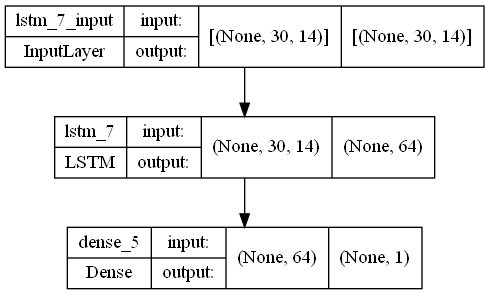

In [7]:
# visualize the model
from keras.utils.vis_utils import plot_model
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

In [5]:
# load saved arima model
from statsmodels.tsa.arima.model import ARIMAResults
import statsmodels.api as sm

ar_model = ARIMAResults.load('./saved_models/arima/arima_model.pkl')
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1460
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9421.055
Date:                Thu, 19 May 2022   AIC                          18872.110
Time:                        17:21:30   BIC                          18951.392
Sample:                    01-01-2017   HQIC                         18901.686
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.861e-17   9.34e-05  -9.49e-13      1.000      -0.000       0.000
open                    -0.4896      0.008    -64.209      0.000      -0.505      -0.475
high                     0.8234      0.008     99.870      0.000       0.807       0.840
low                      0.6300      0.004    149.244      0.000       0.622       0.638
n-transactions           0.0002      0.000      1.539      0.124   -5.94e-05       0.000
cost-per-transaction    -1.4227      0.481     -2.959      0.003      -2.365      -0.480
Gold price              -0.0264      0.045     -0.586      0.558      -0.115       0.062
output-volume         -1.22e-06   6.77e-06     -0.180      0.857   -1.45e-05    1.21e-05
USD-CNY Price          -52.4125     39.150     -1.339      0.181    -129.146      24.321
SVI                     -1.0452      0.516     -2.027      0.043      -2.056      -0.035
Wikiviews                0.0002      0.000      0.816      0.414      -0.000       0.001
ar.L1                   -0.9041      0.038    -23.863      0.000      -0.978      -0.830
ma.L1                   -0.0382      0.042     -0.905      0.365      -0.121       0.045
ma.L2                   -0.7632      0.043    -17.899      0.000      -0.847      -0.680
sigma2                2.442e+04      0.569   4.29e+04      0.000    2.44e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):             12850.28
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.83e+22. Standard errors may be unstable.
"""

## Prepare data for models
- LSTM
- ARIMA

In [6]:
# LSTM model prediction
from sklearn.preprocessing import MinMaxScaler

dataset = train_df.values  # get raw values from dataframe
TIMESTEPS = 30  # n days in the future to predcict
FEATURES = 14  # number of features

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# reshape into X=t and Y=t+1
testX, testY = create_dataset(dataset, TIMESTEPS)

# reshape input to be  [samples, time steps, features]
testX = np.reshape(testX, (testX.shape[0], TIMESTEPS, FEATURES))

In [7]:
train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'estimated-transaction-volume-usd',
       'n-transactions', 'hash-rate', 'difficulty', 'cost-per-transaction',
       'Gold price', 'output-volume', 'trade-volume', 'USD-CNY Price', 'svi',
       'Wikiviews'],
      dtype='object')

In [9]:
# get arima predictions
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split


top_predictors = ['close', 'open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
top_predictors = train_df[top_predictors]

# create a list of dates to predict
exog_last = sm.add_constant(top_predictors.drop(['close'], axis=1))
start_index = exog_last.index.max().date()
end_index10 = start_index + relativedelta(days=10)
end_index30 = start_index + relativedelta(days=30)

Make predictions using both models

In [36]:
# Make predictions
# LSTM: make a prediction on based on the past 30 days and 90 days
yhat_lstm = get_prediction(lstm_model, testX[-TIMESTEPS:], scaler)
yhat_lstm_90 = get_prediction(lstm_model, testX[-TIMESTEPS*3:], scaler)

# ARIMA: Make a 10 day prediction and 30 day prediction
yhat_arima10 = ar_model.predict(start=start_index, end=end_index10, exog=exog_last[-376:])
yhat_arima30 = ar_model.predict(start=start_index, end=end_index30, exog=exog_last[-396:])

Create a date range from the end of the dataset (future) in daily frequency

In [66]:
datelist_future = pd.date_range(train_df.index[-1], periods=TIMESTEPS*3, freq='1d').tolist()
datelist_future[0:5]

[Timestamp('2022-05-19 00:00:00', freq='D'),
 Timestamp('2022-05-20 00:00:00', freq='D'),
 Timestamp('2022-05-21 00:00:00', freq='D'),
 Timestamp('2022-05-22 00:00:00', freq='D'),
 Timestamp('2022-05-23 00:00:00', freq='D')]

Create a dataframe with the predictions and set the created date range as the index
<br> Add a new column 'Actual', by locating the actual closing values from the predictions dataframe

In [30]:
predictions = pd.DataFrame(yhat_lstm_90, columns=['LSTM90']).set_index(pd.Series(datelist_future))
predictions['Actual'] = future_df.loc[min(predictions.index):max(predictions.index)].Close
predictions['LSTM30'] = pd.Series(yhat_lstm, index=datelist_future[:30])
predictions['ARIMA10'] = yhat_arima10
predictions['ARIMA30'] = yhat_arima30
predictions.head()

NameError: name 'yhat_arima10' is not defined

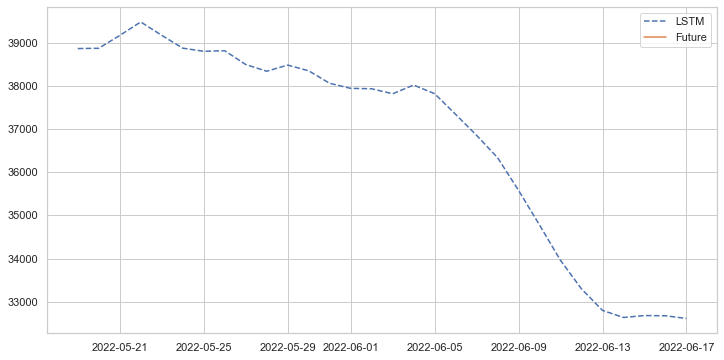

In [26]:
# plot predictsions vs actual
plt.figure(figsize=(12, 6))
# plt.plot(df_3[1900:].close, label='Actual')
plt.plot(predictions.LSTM30, '--', label='LSTM')
# plt.plot(predictions.ARIMA30, '-.', label='ARIMA')
plt.plot(predictions.Actual, label='Future')
plt.legend()
plt.show()

Lets make a prediction with the test data and compare it with the forecasts to see how well the model's have learnt

In [28]:
exog = sm.add_constant(top_predictors.drop(['close'], axis=1))[-31:]

# models test prediction
arima_test_pred = ar_model.forecast(steps=len(exog), exog=exog)
lstm_test_pred = lstm_model.predict(testX)

# models test metrics
lstm_test_pred = inverse_transform(lstm_test_pred, scaler)
lstm_test = forecast_accuracy(lstm_test_pred, train_df[-len(lstm_test_pred):].close.values)
arima_test = forecast_accuracy(arima_test_pred, top_predictors['close'][-31:].values)

# models forecast metrics
lstm = forecast_accuracy(predictions['LSTM30'][:30], predictions['Actual'][:30])
arima = forecast_accuracy(predictions['ARIMA30'][:30], predictions['Actual'][:30])


We can see the scores for each model on their validation and prediction
- ARIMA performed well with validation data and short term predictions
- LSTM had the overall good accuracy

In [256]:
# accuracy of the models
print('LSTM accuracy:', 100-float(lstm['mape'].split('%')[0]),'%')
print('ARIMA accuracy:', 100-float(arima['mape'].split('%')[0]),'%' )
print('LSTM test accuracy:', 100-float(lstm_test['mape'].split('%')[0]),'%') 
print('ARIMA test accuracy:', 100-float(arima_test['mape'].split('%')[0]),'%')

# arima 10 day accuracy
arima_10 = forecast_accuracy(yhat_arima10, predictions['Actual'][:11])
print('ARIMA 10 day accuracy:', 100-float(arima_10['mape'].split('%')[0]),'%')

LSTM accuracy: 94.244 %
ARIMA accuracy: 82.006 %
LSTM test accuracy: 90.869 %
ARIMA test accuracy: 98.13 %
ARIMA 10 day accuracy: 90.648 %


Let's visualize the RMSE and MAE for each model 

In [257]:
metrics_test = pd.DataFrame(data={'model': ['LSTM', 'ARIMA'],
                          'RMSE': [lstm['rmse'], arima['rmse']],
                          'MAE': [lstm['mae'], arima['mae']],
                          'RMSE Validation': [lstm_test['rmse'], arima_test['rmse']],
                          'MAE Validation': [lstm_test['mae'], arima_test['mae']]
                          }
                    )
metrics_test['RMSE'] = metrics_test['RMSE'].astype(float)
metrics_test['MAE'] = metrics_test['MAE'].astype(float)

metrics_test = pd.melt(metrics_test, id_vars="model")
metrics_test.columns = ['model', 'Metrics', 'value']
metrics_test

,model,Metrics,value
0,LSTM,RMSE,2696.141980
1,ARIMA,RMSE,8088.271862
2,LSTM,MAE,2263.257840
3,ARIMA,MAE,7153.430449
4,LSTM,RMSE Validation,4205.391307
5,ARIMA,RMSE Validation,1238.499436
6,LSTM,MAE Validation,2056.394227
7,ARIMA,MAE Validation,926.306939


Text(0.5, 1.0, 'RMSE for all the models')

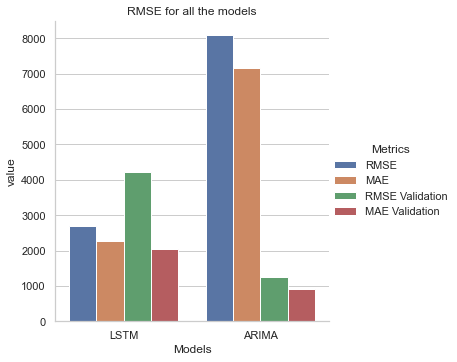

In [259]:
sns.catplot(x='model', y='value', hue='Metrics', data=metrics_test, kind='bar')
plt.xlabel("Models")
plt.title('RMSE for all the models')